# 导入数据

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from collections import Counter
from tqdm import tqdm

# 设置显示，Dataframe展示全部列
pd.set_option('display.max_columns', None) 

In [2]:
# 可视化相关库
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid') # 画图风格设置
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 机器学习相关库
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, roc_curve
from sklearn.decomposition import PCA

In [4]:
# pip install protobuf==5.28.3

In [5]:
# pip install tensorflow

In [4]:
# 深度学习相关库
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [7]:
user_log = pd.read_csv('user_log_format1.csv')
user_info = pd.read_csv('user_info_format1.csv')
train_data = pd.read_csv('train_format1.csv')
test_data = pd.read_csv('test_format1.csv')

In [8]:
user_log.head(5)

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [9]:
user_info.head(5)

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [10]:
train_data.head(5)

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [11]:
test_data.head(5)

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


# 数据探索

In [12]:
def check_data_types(df, df_name):
    """检查数据框的数据类型和空值情况"""
    print(f"{'='*50}")
    print(f"表名: {df_name}")
    print(f"数据形状: {df.shape}")
    print(f"{'='*50}")
    
    print(f"{'列名':<15} {'数据类型':<15} {'空值数量':<10} {'空值比例(%)':<12}")
    print(f"{'-'*50}")
    
    for col in df.columns:
        dtype = df[col].dtype
        null_count = df[col].isnull().sum()
        null_percent = null_count / len(df) * 100 if len(df) > 0 else 0
        
        print(f"{col:<15} {str(dtype):<15} {null_count:<10} {null_percent:<12.2f}")
    
    print()

# 检查所有表
check_data_types(user_log, "user_log (用户行为日志)")
check_data_types(user_info, "user_info (用户画像)")
check_data_types(train_data, "train_data (训练集)")
check_data_types(test_data, "test_data (测试集)")

# 总览统计
print(f"{'='*50}")
print("数据总览")
print(f"{'='*50}")

total_info = []
for df_name, df in [("user_log", user_log), ("user_info", user_info), 
                    ("train_data", train_data), ("test_data", test_data)]:
    total_rows = len(df)
    total_nulls = df.isnull().sum().sum()
    null_percent = total_nulls / (len(df) * len(df.columns)) * 100 if len(df) > 0 else 0
    
    total_info.append({
        "表名": df_name,
        "行数": total_rows,
        "列数": len(df.columns),
        "总空值数": total_nulls,
        "总体空值率(%)": f"{null_percent:.2f}"
    })

# 创建总览表
overview_df = pd.DataFrame(total_info)
print(overview_df.to_string(index=False))

表名: user_log (用户行为日志)
数据形状: (54925330, 7)
列名              数据类型            空值数量       空值比例(%)     
--------------------------------------------------
user_id         int64           0          0.00        
item_id         int64           0          0.00        
cat_id          int64           0          0.00        
seller_id       int64           0          0.00        
brand_id        float64         91015      0.17        
time_stamp      int64           0          0.00        
action_type     int64           0          0.00        

表名: user_info (用户画像)
数据形状: (424170, 3)
列名              数据类型            空值数量       空值比例(%)     
--------------------------------------------------
user_id         int64           0          0.00        
age_range       float64         2217       0.52        
gender          float64         6436       1.52        

表名: train_data (训练集)
数据形状: (260864, 3)
列名              数据类型            空值数量       空值比例(%)     
------------------------------------------------

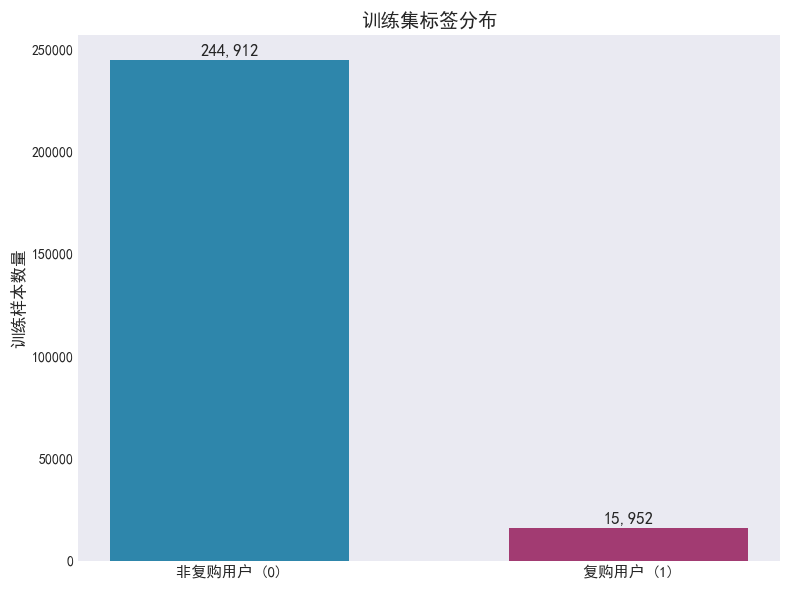

训练集标签统计:
非复购用户 (0): 244,912 个样本 (93.88%)
复购用户 (1): 15,952 个样本 (6.12%)


In [13]:
label_counts = train_data['label'].value_counts().sort_index()
label_names = ['非复购用户 (0)', '复购用户 (1)']

plt.figure(figsize=(8, 6))

# 绘制条形图
bars = plt.bar(label_names, label_counts.values, 
               color=['#2E86AB', '#A23B72'], 
               width=0.6)

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1000,
             f'{height:,}', ha='center', va='bottom', fontsize=12)

# 设置图表属性
plt.title('训练集标签分布', fontsize=14, fontweight='bold')
plt.ylabel('训练样本数量', fontsize=12)
plt.grid(False)
plt.xticks(fontsize=11)

# 显示图表
plt.tight_layout()
plt.show()

# 打印统计信息
print("训练集标签统计:")
for i, (label, count) in enumerate(label_counts.items()):
    percentage = count / len(train_data) * 100
    print(f"{label_names[i]}: {count:,} 个样本 ({percentage:.2f}%)")

- 训练集标签正负分布极不平衡，复购用户远远少于非复购用户，后续训练中要对这个问题进行处理

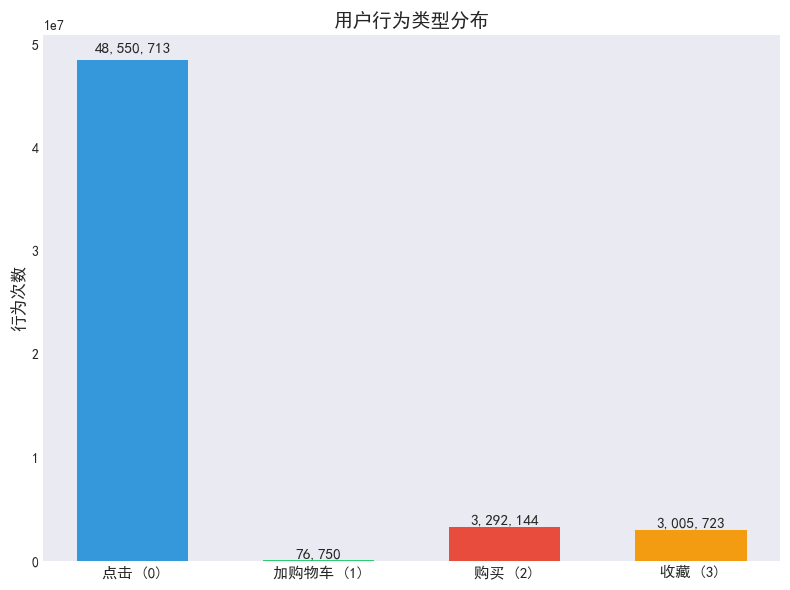

用户行为类型统计:
点击 (0): 48,550,713 次 (88.39%)
加购物车 (1): 76,750 次 (0.14%)
购买 (2): 3,292,144 次 (5.99%)
收藏 (3): 3,005,723 次 (5.47%)


In [14]:
action_counts = user_log['action_type'].value_counts().sort_index()
action_names = {
    0: '点击 (0)',
    1: '加购物车 (1)',
    2: '购买 (2)',
    3: '收藏 (3)'
}

plt.figure(figsize=(8, 6))

# 绘制条形图
bars = plt.bar([action_names[i] for i in action_counts.index], 
               action_counts.values,
               color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'],
               width=0.6)

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
             f'{height:,}', ha='center', va='bottom', fontsize=11)

# 设置图表属性
plt.title('用户行为类型分布', fontsize=14, fontweight='bold')
plt.ylabel('行为次数', fontsize=12)
plt.grid(False)
plt.xticks(fontsize=11)

# 显示图表
plt.tight_layout()
plt.show()

# 打印统计信息
print("用户行为类型统计:")
for action_type, count in action_counts.items():
    percentage = count / len(user_log) * 100
    print(f"{action_names[action_type]}: {count:,} 次 ({percentage:.2f}%)")

- 点击行为占比极大，占了88%以上；
- 购买和收藏行为占比相当
- 收藏行为占比最小，仅有0.14%

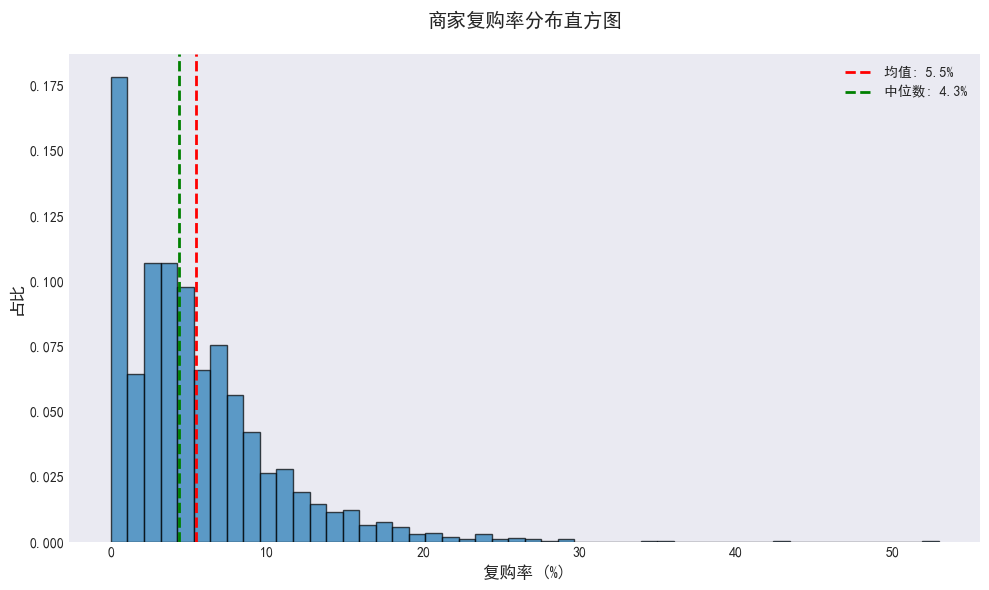

In [15]:
# 计算各商家复购率
merchant_stats = train_data.groupby('merchant_id')['label'].agg([
    ('repeat_rate', lambda x: x.mean() * 100)  # 复购率（百分比）
]).reset_index()

# 绘制复购率直方图
plt.figure(figsize=(10, 6))

# 绘制直方图
plt.hist(merchant_stats['repeat_rate'], bins=50, color='#1f77b4', 
         edgecolor='black', alpha=0.7, density=True)

# 添加标题和标签
plt.title('商家复购率分布直方图', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('复购率 (%)', fontsize=12)
plt.ylabel('占比', fontsize=12)
plt.grid(False)

# 添加平均值和中位数的垂直线
plt.axvline(merchant_stats['repeat_rate'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f'均值: {merchant_stats["repeat_rate"].mean():.1f}%')
plt.axvline(merchant_stats['repeat_rate'].median(), color='green', linestyle='--', 
           linewidth=2, label=f'中位数: {merchant_stats["repeat_rate"].median():.1f}%')

# 添加图例
plt.legend()

# 显示图表
plt.tight_layout()
plt.show()

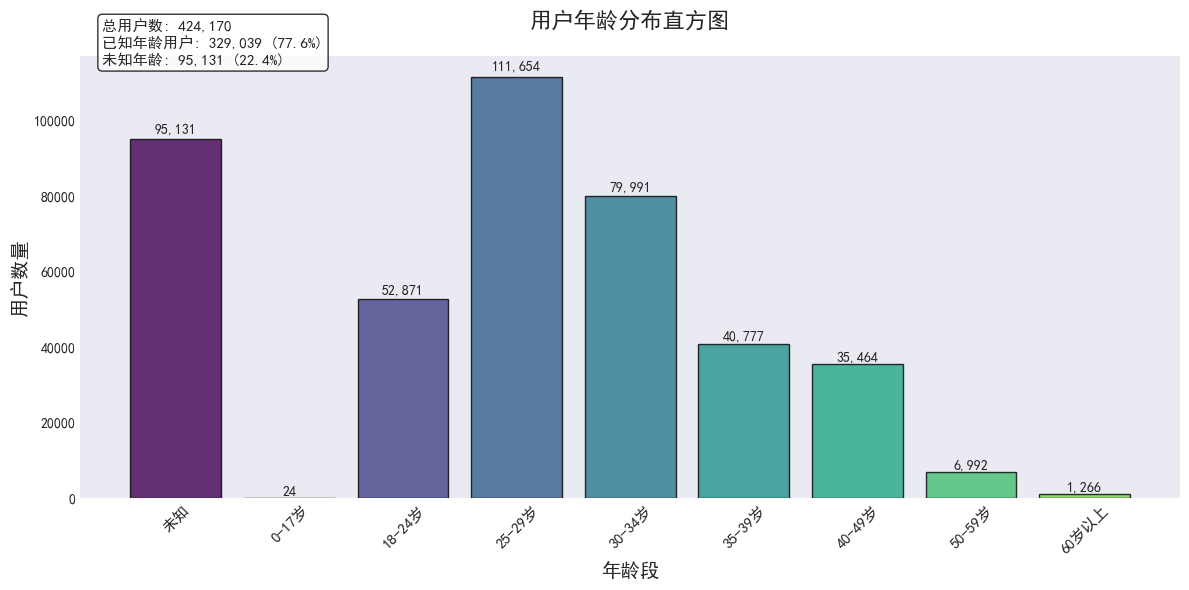

In [16]:
def plot_age_distribution(user_info):
    """
    绘制用户年龄分布的直方图
    
    参数:
        user_info: 用户画像数据框
    """
    try:
        # 检查数据是否存在
        if user_info is None or 'age_range' not in user_info.columns:
            print("错误: 用户画像数据缺失或缺少age_range列")
            return
        
        # 处理缺失值
        age_data = user_info['age_range'].fillna(0).astype(int)
        
        # 统计各个年龄段的用户数量
        age_counts = age_data.value_counts().sort_index()
        
        # 设置年龄段的标签
        age_labels = {
            0: '未知',
            1: '0-17岁',
            2: '18-24岁',
            3: '25-29岁',
            4: '30-34岁',
            5: '35-39岁',
            6: '40-49岁',
            7: '50-59岁',
            8: '60岁以上'
        }
        
        # 创建年龄标签列表
        labels = [age_labels.get(age, f'年龄{age}') for age in age_counts.index]
        
        # 创建图表
        plt.figure(figsize=(12, 6))
        
        # 绘制直方图
        bars = plt.bar(labels, age_counts.values, 
                      color=plt.cm.viridis(np.linspace(0, 0.8, len(age_counts))),
                      edgecolor='black', alpha=0.8)
        
        # 添加数值标签
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                    f'{height:,}', ha='center', va='bottom', fontsize=10)
        
        # 设置图表属性
        plt.title('用户年龄分布直方图', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('年龄段', fontsize=14)
        plt.ylabel('用户数量', fontsize=14)
        plt.xticks(rotation=45, fontsize=11)
        plt.grid(False)
        
        # 添加统计信息
        total_users = len(age_data)
        unknown_users = age_counts.get(0, 0)
        known_users = total_users - unknown_users
        
        plt.text(0.02, 0.98, f'总用户数: {total_users:,}\n已知年龄用户: {known_users:,} ({known_users/total_users*100:.1f}%)\n未知年龄: {unknown_users:,} ({unknown_users/total_users*100:.1f}%)',
                transform=plt.gca().transAxes, fontsize=11,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"绘制年龄分布图时出错: {str(e)}")

plot_age_distribution(user_info)

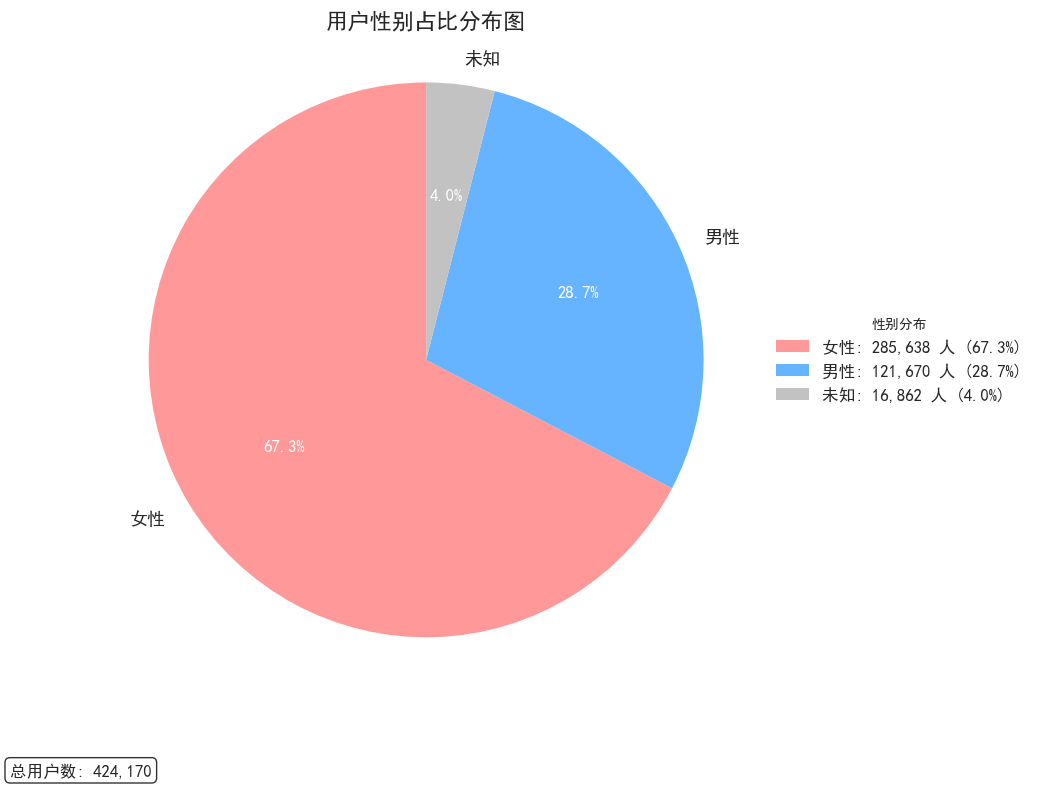

In [17]:
def plot_gender_pie_chart(user_info):
    """
    绘制用户性别占比的扇形图
    
    参数:
        user_info: 用户画像数据框
    """
    try:
        # 检查数据是否存在
        if user_info is None or 'gender' not in user_info.columns:
            print("错误: 用户画像数据缺失或缺少gender列")
            return
        
        # 处理缺失值（将2和NaN都视为未知）
        gender_data = user_info['gender'].fillna(2).astype(int)
        
        # 统计性别分布
        gender_counts = gender_data.value_counts().sort_index()
        
        # 设置性别标签
        gender_labels = {
            0: '女性',
            1: '男性', 
            2: '未知'
        }
        
        # 创建标签列表
        labels = [gender_labels.get(gender, f'性别{gender}') for gender in gender_counts.index]
        
        # 设置颜色
        colors = ['#ff9999', '#66b3ff', '#c2c2c2']  # 女性红色，男性蓝色，未知灰色
        
        # 创建图表
        plt.figure(figsize=(10, 8))
        
        # 绘制扇形图
        wedges, texts, autotexts = plt.pie(gender_counts.values, 
                                          labels=labels, 
                                          colors=colors[:len(gender_counts)],
                                          autopct='%1.1f%%',
                                          startangle=90,
                                          shadow=False,
                                          textprops={'fontsize': 13})
        
        # 设置数值标签样式
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(12)
        
        # 设置标签样式
        for text in texts:
            text.set_fontsize(13)
        
        # 添加标题
        plt.title('用户性别占比分布图', fontsize=16, fontweight='bold', pad=20)
        
        # 添加图例
        legend_labels = []
        for gender, count in gender_counts.items():
            percentage = count / len(gender_data) * 100
            legend_labels.append(f'{gender_labels.get(gender, f"性别{gender}")}: {count:,} 人 ({percentage:.1f}%)')
        
        plt.legend(wedges, legend_labels, 
                  title="性别分布", 
                  loc="center left", 
                  bbox_to_anchor=(1, 0, 0.5, 1),
                  fontsize=12)
        
        # 添加总用户数信息
        total_users = len(gender_data)
        plt.text(-1.5, -1.5, f'总用户数: {total_users:,}', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # 确保圆形
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"绘制性别扇形图时出错: {str(e)}")

plot_gender_pie_chart(user_info)

# 数据预处理

In [23]:
# user_info:年龄、性别列存在null值，填补空值

# age_range中0和null统一为未知
user_info["age_range"].fillna(0,inplace = True)
user_info["age_label"] = user_info['age_range'].map({
    0: '未知',
    1: '0-17岁',
    2: '18-24岁',
    3: '25-29岁',
    4: '30-34岁',
    5: '35-39岁',
    6: '40-49岁',
    7: '50-59岁',
    8: '60岁以上'
})

# 将NaN填充为2（未知），然后统一映射
user_info['gender'] = user_info['gender'].fillna(2)
user_info['gender_label'] = user_info['gender'].map({
    0: '女性', 
    1: '男性', 
    2: '未知'
})

check_data_types(user_info, "处理后的user_info (用户画像)")

表名: 处理后的user_info (用户画像)
数据形状: (424170, 5)
列名              数据类型            空值数量       空值比例(%)     
--------------------------------------------------
user_id         int64           0          0.00        
age_range       float64         0          0.00        
gender          float64         0          0.00        
age_label       object          0          0.00        
gender_label    object          0          0.00        



In [24]:
# user_log:brand_id中没有-1，故空值均用-1进行填充
user_log['brand_id'] = user_log['brand_id'].fillna(-1)

# 处理时间戳格式
user_log['month'] = user_log['time_stamp'] // 100
user_log['day'] = user_log['time_stamp'] % 100

check_data_types(user_log, "处理后的user_log (用户行为日志)")

表名: 处理后的user_log (用户行为日志)
数据形状: (54925330, 9)
列名              数据类型            空值数量       空值比例(%)     
--------------------------------------------------
user_id         int64           0          0.00        
item_id         int64           0          0.00        
cat_id          int64           0          0.00        
seller_id       int64           0          0.00        
brand_id        float64         0          0.00        
time_stamp      int64           0          0.00        
action_type     int64           0          0.00        
month           int64           0          0.00        
day             int64           0          0.00        



# 特征工程

In [5]:
# ==================== 特征工程类 ====================
class FeatureEngineering:
    """特征工程类 - 从原始数据中提取机器学习特征"""
    
    def __init__(self):
        """初始化特征工程类"""
        self.feature_names = []  # 存储特征名称
        self.scaler = StandardScaler()  # 特征标准化器
        self.label_encoders = {}  # 标签编码器字典
    
    def create_features(self, train_data, test_data, user_log, user_info):
        """
        创建所有特征
        
        参数:
            train_data: 训练集数据
            test_data: 测试集数据
            user_log: 用户行为日志
            user_info: 用户画像数据
        
        返回:
            X_train: 训练特征
            y_train: 训练标签
            X_test: 测试特征
            test_ids: 测试集ID
        """
        print("开始特征工程...")
        
        # 1. 合并训练和测试数据，统一处理
        all_data = pd.concat([train_data, test_data], ignore_index=True)
        
        # 2. 提取基础特征
        print("步骤1: 提取基础特征...")
        basic_features = self._extract_basic_features(all_data, user_info)
        
        # 3. 提取用户行为特征
        print("步骤2: 提取用户行为特征...")
        behavior_features = self._extract_behavior_features(all_data, user_log)
        
        # 4. 提取用户-商家交互特征
        print("步骤3: 提取用户-商家交互特征...")
        interaction_features = self._extract_interaction_features(all_data, user_log)
        
        # 5. 提取时间特征
        print("步骤4: 提取时间特征...")
        time_features = self._extract_time_features(all_data, user_log)
        
        # 6. 提取商家特征
        print("步骤5: 提取商家特征...")
        merchant_features = self._extract_merchant_features(all_data, user_log)
        
        # 7. 合并所有特征
        print("步骤6: 合并所有特征...")
        all_features = pd.concat([
            basic_features,
            behavior_features,
            interaction_features,
            time_features,
            merchant_features
        ], axis=1)
        
        # 8. 分离训练集和测试集
        train_size = len(train_data)
        X_train = all_features.iloc[:train_size].copy()
        X_test = all_features.iloc[train_size:].copy()
        y_train = train_data['label'].copy()
        test_ids = test_data[['user_id', 'seller_id']].copy()
        
        # 9. 特征预处理
        X_train_processed, X_test_processed = self._preprocess_features(X_train, X_test)
        
        print(f"特征工程完成!")
        print(f"训练特征维度: {X_train_processed.shape}")
        print(f"测试特征维度: {X_test_processed.shape}")
        
        return X_train_processed, y_train, X_test_processed, test_ids
    
    def _extract_basic_features(self, data, user_info):
        """提取基础特征 - 用户基本属性特征"""
        features = pd.DataFrame(index=data.index)
        
        # 用户画像特征
        user_features = data.merge(user_info[['user_id', 'age_range', 'gender', 
                                            'age_label', 'gender_label']], 
                                 on='user_id', how='left')
        
        # 1. 用户人口统计特征
        features['age_range'] = user_features['age_range']
        features['gender'] = user_features['gender']
        
        # 2. 年龄分段特征
        features['is_young'] = (features['age_range'].isin([1, 2])).astype(int)  # 年轻用户
        features['is_middle'] = (features['age_range'].isin([3, 4, 5])).astype(int)  # 中年用户
        features['is_senior'] = (features['age_range'].isin([6, 7, 8])).astype(int)  # 年长用户
        
        # 3. 性别特征-虚拟变量：is_female, is_male (当两者都为0时，表示性别未知)
        features['is_female'] = (features['gender'] == 0).astype(int)
        features['is_male'] = (features['gender'] == 1).astype(int)
        
        print(f"基础特征提取完成: {features.shape[1]}个特征")
        return features
    
    def _extract_behavior_features(self, data, user_log):
        """提取用户行为特征 - 用户的整体行为模式"""
        features = data[['user_id']].copy()
        
        # 按用户统计行为
        user_behavior = user_log.groupby('user_id').agg({
            'action_type': ['count', lambda x: (x == 0).sum(), lambda x: (x == 1).sum(), 
                          lambda x: (x == 2).sum(), lambda x: (x == 3).sum()],
            'item_id': 'nunique',
            'cat_id': 'nunique',
            'brand_id': lambda x: (x != -1).sum()  # 有效品牌数
        })
        user_behavior.columns = ['total_actions', 'clicks', 'add_cart', 
                                'purchases', 'favorites', 'unique_items',
                                'unique_cats', 'valid_brands']
        # 根据user_id统计了总行为数,点击数,加购数,购买数,收藏数,浏览商品数,浏览商品类数,浏览品牌数
        
        # 合并到特征中
        features = features.merge(user_behavior, left_on='user_id', 
                                right_index=True, how='left')
        
        # 1. 行为比例特征:点击比例,加购比例,购买比例,收藏比例
        features['click_ratio'] = features['clicks'] / features['total_actions'].replace(0, 1)
        features['cart_ratio'] = features['add_cart'] / features['total_actions'].replace(0, 1)
        features['purchase_ratio'] = features['purchases'] / features['total_actions'].replace(0, 1)
        features['favorite_ratio'] = features['favorites'] / features['total_actions'].replace(0, 1)
        
        # 2. 行为转化特征:点击到加购的转化率,加购到购买的转化率
        features['click_to_cart_rate'] = features['add_cart'] / features['clicks'].replace(0, 1)
        features['cart_to_purchase_rate'] = features['purchases'] / features['add_cart'].replace(0, 1)
        
        # 3. 用户多样性特征:商品多样性,品类集中度,品牌覆盖度
        features['item_diversity'] = features['unique_items'] / features['total_actions'].replace(0, 1)
        features['cat_diversity'] = features['unique_cats'] / features['unique_items'].replace(0, 1)
        features['brand_coverage'] = features['valid_brands'] / features['total_actions'].replace(0, 1)
        
        # 填充缺失值
        features = features.fillna(0)
        
        print(f"行为特征提取完成: {features.shape[1]}个特征")
        return features
    
    def _extract_interaction_features(self, data, user_log):
        """提取用户-商家交互特征 - 用户在特定商家的行为模式"""
        features = pd.DataFrame(index=data.index)
        
        # 用户-商家交互统计
        for idx, row in data.iterrows():
            user_id = row['user_id']
            seller_id = row['seller_id']
            
            # 筛选该用户在目标商家的行为
            user_seller_log = user_log[(user_log['user_id'] == user_id) & 
                                      (user_log['seller_id'] == seller_id)]
            
            if not user_seller_log.empty:
                # 交互行为统计:用户在该商家的总行为次数,以及点击,加购,购买,收藏四类型为的具体频次
                action_counts = user_seller_log['action_type'].value_counts() # 四种行为类型次数统计字典
                
                features.loc[idx, 'interaction_total'] = len(user_seller_log)
                features.loc[idx, 'interaction_clicks'] = action_counts.get(0, 0)
                features.loc[idx, 'interaction_carts'] = action_counts.get(1, 0)
                features.loc[idx, 'interaction_purchases'] = action_counts.get(2, 0)
                features.loc[idx, 'interaction_favorites'] = action_counts.get(3, 0)
                
                # 交互多样性:用户在该商家交互过的商品数,品类数,品牌数
                features.loc[idx, 'interaction_unique_items'] = user_seller_log['item_id'].nunique()
                features.loc[idx, 'interaction_unique_cats'] = user_seller_log['cat_id'].nunique()
                features.loc[idx, 'interaction_unique_brands'] = user_seller_log['brand_id'].nunique()
                
                # 时间相关:用户首次和最近一次与该商家互动的日期,两者之间的天数跨度
                features.loc[idx, 'interaction_first_day'] = user_seller_log['day'].min()
                features.loc[idx, 'interaction_last_day'] = user_seller_log['day'].max()
                features.loc[idx, 'interaction_day_span'] = (user_seller_log['day'].max() - 
                                                           user_seller_log['day'].min())
            else:
                # 无交互记录
                features.loc[idx, 'interaction_total'] = 0
                features.loc[idx, 'interaction_clicks'] = 0
                features.loc[idx, 'interaction_carts'] = 0
                features.loc[idx, 'interaction_purchases'] = 0
                features.loc[idx, 'interaction_favorites'] = 0
                features.loc[idx, 'interaction_unique_items'] = 0
                features.loc[idx, 'interaction_unique_cats'] = 0
                features.loc[idx, 'interaction_unique_brands'] = 0
                features.loc[idx, 'interaction_first_day'] = -1
                features.loc[idx, 'interaction_last_day'] = -1
                features.loc[idx, 'interaction_day_span'] = 0
        
        # 交互强度特征
        # 交互强度：总交互次数归一化处理,用于衡量用户对该商家的关注程度
        # 购买强度：在该商家的购买次数占其总交互次数的比例
        features['interaction_intensity'] = features['interaction_total'] / (data.index.max() + 1)
        features['purchase_intensity'] = features['interaction_purchases'] / (features['interaction_total'] + 1)
        
        print(f"交互特征提取完成: {features.shape[1]}个特征")
        return features
    
    def _extract_time_features(self, data, user_log):
        """提取时间特征 - 用户行为的时间模式"""
        features = data[['user_id']].copy()
        
        # 用户整体时间特征
        user_time_stats = user_log.groupby('user_id').agg({
            'month': ['min', 'max', 'nunique'],
            'day': ['min', 'max', 'mean', 'std']
        })
        # 最早和最晚活跃月份,活跃过的月份数量,行为发生日期的最小值,最大值,均值,标准差
        user_time_stats.columns = ['first_month', 'last_month', 'active_months',
                                 'first_day', 'last_day', 'mean_day', 'std_day']
        
        features = features.merge(user_time_stats, left_on='user_id', 
                                right_index=True, how='left')
        
        # 1. 活跃度时间特征:活跃周期,行为日期的标准差
        features['active_period'] = features['last_month'] - features['first_month']
        features['day_variation'] = features['std_day'].fillna(0)
        
        # 2. 行为节奏特征
        features['is_consistent'] = (features['std_day'] < 5).astype(int)  # 行为时间是否集中
        
        # 3. 近期活跃特征
        features['recent_activity'] = (features['last_month'] == 11).astype(int)  # 是否最近活跃
        
        # 填充缺失值
        features = features.fillna(0)
        
        print(f"时间特征提取完成: {features.shape[1]}个特征")
        return features
    
    def _extract_merchant_features(self, data, user_log):
        """提取商家特征 - 商家的属性"""
        features = data[['seller_id']].copy()
        
        # 商家行为统计
        merchant_stats = user_log.groupby('seller_id').agg({
            'user_id': 'nunique',
            'action_type': ['count', lambda x: (x == 2).sum()],
            'item_id': 'nunique',
            'cat_id': 'nunique'
        })
        # 服务过的独立用户数,总行为次数,总购买次数,涉及商品数及品类数
        merchant_stats.columns = ['unique_users', 'total_actions', 
                                'total_purchases', 'unique_items', 'unique_cats']
        
        features = features.merge(merchant_stats, left_on='seller_id', 
                                right_index=True, how='left')
        
        # 1. 商家活跃度特征:人气指数,活跃指数
        features['merchant_popularity'] = features['unique_users'] / features['unique_users'].max() # 全局最大值
        features['merchant_activity'] = features['total_actions'] / features['total_actions'].max()
        
        # 2. 商家转化率特征
        features['merchant_conversion_rate'] = features['total_purchases'] / features['total_actions'].replace(0, 1)
        
        # 3. 商家多样性特征
        features['merchant_diversity'] = features['unique_cats'] / features['unique_items'].replace(0, 1)
        
        # 4. 商家规模特征
        features['merchant_size_small'] = (features['unique_users'] < 100).astype(int)
        features['merchant_size_medium'] = ((features['unique_users'] >= 100) & 
                                          (features['unique_users'] < 1000)).astype(int)
        features['merchant_size_large'] = (features['unique_users'] >= 1000).astype(int)
        
        # 填充缺失值
        features = features.fillna(0)
        
        print(f"商家特征提取完成: {features.shape[1]}个特征")
        return features
    
    def _preprocess_features(self, X_train, X_test):
        """特征预处理 - 标准化和编码"""
        
        # 1. 处理无穷大值
        X_train = X_train.replace([np.inf, -np.inf], np.nan)
        X_test = X_test.replace([np.inf, -np.inf], np.nan)
        
        # 2. 填充缺失值
        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)
        
        # 3. 特征标准化（仅对数值特征）
        numerical_cols = X_train.select_dtypes(include=[np.number]).columns
        X_train_numerical = self.scaler.fit_transform(X_train[numerical_cols])
        X_test_numerical = self.scaler.transform(X_test[numerical_cols])
        
        # 更新特征
        X_train[numerical_cols] = X_train_numerical
        X_test[numerical_cols] = X_test_numerical
        
        # 4. 保存特征名称
        self.feature_names = X_train.columns.tolist()
        
        return X_train, X_test

In [6]:
# ==================== 模型训练和评估类 ====================
class ModelTrainer:
    """模型训练和评估类 - 训练和比较多个模型"""
    
    def __init__(self, random_state=42, n_folds=5):
        """
        初始化模型训练器
        
        参数:
            random_state: 随机种子
            n_folds: 交叉验证折数
        """
        self.random_state = random_state
        self.n_folds = n_folds
        self.models = {}
        self.results = {}
        self.best_params = {}
        self.cv_scores = {}  # 存储交叉验证结果
    
    def train_and_evaluate(self, X_train, y_train, X_test, test_ids):
        """
        训练和评估多个模型（使用交叉验证）
        
        参数:
            X_train: 训练特征（有标签）
            y_train: 训练标签
            X_test: 测试特征（无标签，用于最终预测）
            test_ids: 测试集ID
        
        返回:
            predictions: 所有模型的预测结果
        """
        print("\n" + "="*60)
        print("开始模型训练和评估（交叉验证）")
        print("="*60)
        
        print(f"训练集大小: {X_train.shape}")
        print(f"测试集大小: {X_test.shape}")
        print(f"训练集正样本比例: {y_train.mean():.4f}")
        
        # 使用StratifiedKFold确保每折的正负样本比例一致
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, 
                             random_state=self.random_state)
        
        # 1. 逻辑回归模型
        print("\n>>> 1. 训练逻辑回归模型")
        lr_predictions = self._train_logistic_regression(X_train, y_train, X_test, skf)
        
        # 2. 随机森林模型
        print("\n>>> 2. 训练随机森林模型")
        rf_predictions = self._train_random_forest(X_train, y_train, X_test, skf)
        
        # 3. DNN神经网络模型
        print("\n>>> 3. 训练DNN神经网络模型")
        dnn_predictions = self._train_dnn(X_train, y_train, X_test, skf)
        
        # 4. 模型性能对比
        print("\n" + "="*60)
        print("模型性能对比（交叉验证结果）")
        print("="*60)
        self._compare_models()
        
        # 5. 生成提交文件
        predictions = {
            'LR': lr_predictions,
            'RF': rf_predictions,
            'DNN': dnn_predictions
        }
        
        return predictions
    
    def _train_logistic_regression(self, X_train, y_train, X_test, skf):
        """训练逻辑回归模型（使用交叉验证）"""
        print("逻辑回归模型调参中...")
        
        # 定义参数网格
        param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga'],
            'max_iter': [100, 200, 500],
            'class_weight': [None, 'balanced']
        }
        
        # 网格搜索调参（使用交叉验证）
        lr = LogisticRegression(random_state=self.random_state)
        grid_search = GridSearchCV(
            lr, param_grid, cv=skf, scoring='roc_auc', 
            n_jobs=-1, verbose=1
        )
        
        print("正在进行网格搜索...")
        grid_search.fit(X_train, y_train)
        
        # 获取最佳模型
        best_lr = grid_search.best_estimator_
        self.models['LogisticRegression'] = best_lr
        self.best_params['LR'] = grid_search.best_params_
        
        # 交叉验证结果
        cv_results = grid_search.cv_results_
        self.cv_scores['LR'] = {
            'mean_cv_auc': grid_search.best_score_,
            'std_cv_auc': cv_results['std_test_score'][grid_search.best_index_],
            'all_cv_scores': cross_val_score(best_lr, X_train, y_train, 
                                            cv=skf, scoring='roc_auc')
        }
        
        print(f"最佳参数: {grid_search.best_params_}")
        print(f"交叉验证平均AUC: {grid_search.best_score_:.4f} (±{self.cv_scores['LR']['std_cv_auc']:.4f})")
        print(f"各折AUC得分: {self.cv_scores['LR']['all_cv_scores']}")
        
        # 保存结果
        self.results['LR'] = {
            'cv_auc_mean': grid_search.best_score_,
            'cv_auc_std': self.cv_scores['LR']['std_cv_auc'],
            'best_params': grid_search.best_params_
        }
        
        # 在整个训练集上重新训练最佳模型
        print("在整个训练集上重新训练最佳模型...")
        final_model = LogisticRegression(**grid_search.best_params_, 
                                        random_state=self.random_state)
        final_model.fit(X_train, y_train)
        self.models['LogisticRegression_final'] = final_model
        
        # 预测测试集
        test_pred = final_model.predict_proba(X_test)[:, 1]
        return test_pred
    
    def _train_random_forest(self, X_train, y_train, X_test, skf):
        """训练随机森林模型（使用交叉验证）"""
        print("随机森林模型调参中...")
        
        # 定义参数网格
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'class_weight': [None, 'balanced', 'balanced_subsample']
        }
        
        # 使用随机搜索（因为随机森林训练较慢）
        from sklearn.model_selection import RandomizedSearchCV
        rf = RandomForestClassifier(random_state=self.random_state, n_jobs=-1)
        
        random_search = RandomizedSearchCV(
            rf, param_grid, n_iter=20, cv=skf, 
            scoring='roc_auc', n_jobs=-1, 
            random_state=self.random_state, verbose=1
        )
        
        print("正在进行随机搜索...")
        random_search.fit(X_train, y_train)
        
        # 获取最佳模型
        best_rf = random_search.best_estimator_
        self.models['RandomForest'] = best_rf
        self.best_params['RF'] = random_search.best_params_
        
        # 交叉验证结果
        cv_results = random_search.cv_results_
        self.cv_scores['RF'] = {
            'mean_cv_auc': random_search.best_score_,
            'std_cv_auc': cv_results['std_test_score'][random_search.best_index_],
            'all_cv_scores': cross_val_score(best_rf, X_train, y_train, 
                                            cv=skf, scoring='roc_auc')
        }
        
        print(f"最佳参数: {random_search.best_params_}")
        print(f"交叉验证平均AUC: {random_search.best_score_:.4f} (±{self.cv_scores['RF']['std_cv_auc']:.4f})")
        print(f"各折AUC得分: {self.cv_scores['RF']['all_cv_scores']}")
        
        # 保存结果
        self.results['RF'] = {
            'cv_auc_mean': random_search.best_score_,
            'cv_auc_std': self.cv_scores['RF']['std_cv_auc'],
            'best_params': random_search.best_params_
        }
        
        # 在整个训练集上重新训练最佳模型
        print("在整个训练集上重新训练最佳模型...")
        final_model = RandomForestClassifier(**random_search.best_params_,
                                           random_state=self.random_state,
                                           n_jobs=-1)
        final_model.fit(X_train, y_train)
        self.models['RandomForest_final'] = final_model
        
        # 预测测试集
        test_pred = final_model.predict_proba(X_test)[:, 1]
        return test_pred
    
    def _train_dnn(self, X_train, y_train, X_test, skf):
        """训练DNN神经网络模型（使用交叉验证）"""
        print("DNN神经网络模型调参中...")
        
        # 设置随机种子
        tf.random.set_seed(self.random_state)
        
        # 定义DNN架构
        def create_dnn_model(input_dim, learning_rate=0.001, dropout_rate=0.3):
            """创建DNN模型"""
            model = Sequential([
                Dense(256, activation='relu', input_dim=input_dim, 
                      kernel_regularizer=l2(0.001)),
                BatchNormalization(),
                Dropout(dropout_rate),
                
                Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
                BatchNormalization(),
                Dropout(dropout_rate),
                
                Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
                BatchNormalization(),
                Dropout(dropout_rate * 0.5),
                
                Dense(32, activation='relu'),
                Dropout(dropout_rate * 0.5),
                
                Dense(1, activation='sigmoid')
            ])
            
            model.compile(
                optimizer=Adam(learning_rate=learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
            )
            
            return model
        
        # 由于DNN交叉验证训练时间较长，我们使用一种简化的方式：
        # 1. 先用部分数据快速调参
        # 2. 再用最佳参数在整个训练集上训练
        
        # 先抽样一部分数据进行快速调参
        sample_size = min(20000, len(X_train))
        if sample_size < len(X_train):
            print(f"使用{sample_size:,}个样本进行快速调参...")
            indices = np.random.choice(len(X_train), sample_size, replace=False)
            X_sample = X_train.iloc[indices] if isinstance(X_train, pd.DataFrame) else X_train[indices]
            y_sample = y_train.iloc[indices] if isinstance(y_train, pd.Series) else y_train[indices]
        else:
            X_sample, y_sample = X_train, y_train
        
        # 超参数调优
        learning_rates = [0.001, 0.0005]
        dropout_rates = [0.2, 0.3]
        batch_sizes = [64, 128]
        
        best_auc = 0
        best_params = {}
        best_history = None
        
        # 简单的网格搜索
        for lr in learning_rates:
            for dropout in dropout_rates:
                for batch_size in batch_sizes:
                    print(f"测试参数: lr={lr}, dropout={dropout}, batch_size={batch_size}")
                    
                    # 创建模型
                    model = create_dnn_model(X_sample.shape[1], lr, dropout)
                    
                    # 回调函数
                    callbacks = [
                        EarlyStopping(monitor='val_auc', patience=5, 
                                     mode='max', restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_auc', factor=0.5, 
                                         patience=3, min_lr=1e-6)
                    ]
                    
                    # 划分训练验证集
                    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
                        X_sample, y_sample, test_size=0.2, 
                        random_state=self.random_state, stratify=y_sample
                    )
                    
                    # 训练模型
                    history = model.fit(
                        X_train_split, y_train_split,
                        validation_data=(X_val_split, y_val_split),
                        epochs=30,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        verbose=0
                    )
                    
                    # 评估模型
                    val_auc = history.history['val_auc'][-1]
                    
                    if val_auc > best_auc:
                        best_auc = val_auc
                        best_params = {
                            'learning_rate': lr,
                            'dropout_rate': dropout,
                            'batch_size': batch_size,
                            'epochs': len(history.history['loss'])
                        }
                        best_history = history
        
        # 使用交叉验证评估最佳参数
        print("使用交叉验证评估最佳参数...")
        cv_auc_scores = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            print(f"  训练第{fold_idx+1}折...")
            
            X_train_fold = X_train.iloc[train_idx] if isinstance(X_train, pd.DataFrame) else X_train[train_idx]
            X_val_fold = X_train.iloc[val_idx] if isinstance(X_train, pd.DataFrame) else X_train[val_idx]
            y_train_fold = y_train.iloc[train_idx] if isinstance(y_train, pd.Series) else y_train[train_idx]
            y_val_fold = y_train.iloc[val_idx] if isinstance(y_train, pd.Series) else y_train[val_idx]
            
            # 创建模型
            model = create_dnn_model(X_train.shape[1], 
                                    best_params['learning_rate'],
                                    best_params['dropout_rate'])
            
            # 回调函数
            callbacks = [
                EarlyStopping(monitor='val_auc', patience=10, 
                             mode='max', restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_auc', factor=0.5, 
                                 patience=5, min_lr=1e-6)
            ]
            
            # 训练模型
            history = model.fit(
                X_train_fold, y_train_fold,
                validation_data=(X_val_fold, y_val_fold),
                epochs=50,
                batch_size=best_params['batch_size'],
                callbacks=callbacks,
                verbose=0
            )
            
            # 获取最佳验证AUC
            best_val_auc = max(history.history['val_auc'])
            cv_auc_scores.append(best_val_auc)
        
        # 保存结果
        mean_cv_auc = np.mean(cv_auc_scores)
        std_cv_auc = np.std(cv_auc_scores)
        
        self.cv_scores['DNN'] = {
            'mean_cv_auc': mean_cv_auc,
            'std_cv_auc': std_cv_auc,
            'all_cv_scores': cv_auc_scores
        }
        
        self.models['DNN'] = create_dnn_model(X_train.shape[1], 
                                             best_params['learning_rate'],
                                             best_params['dropout_rate'])
        self.best_params['DNN'] = best_params
        
        print(f"最佳参数: {best_params}")
        print(f"交叉验证平均AUC: {mean_cv_auc:.4f} (±{std_cv_auc:.4f})")
        print(f"各折AUC得分: {cv_auc_scores}")
        
        # 保存结果
        self.results['DNN'] = {
            'cv_auc_mean': mean_cv_auc,
            'cv_auc_std': std_cv_auc,
            'best_params': best_params
        }
        
        # 在整个训练集上重新训练最佳模型
        print("在整个训练集上重新训练最佳模型...")
        final_model = create_dnn_model(X_train.shape[1], 
                                      best_params['learning_rate'],
                                      best_params['dropout_rate'])
        
        # 划分验证集用于早停
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train, y_train, test_size=0.2, 
            random_state=self.random_state, stratify=y_train
        )
        
        callbacks = [
            EarlyStopping(monitor='val_auc', patience=10, 
                         mode='max', restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_auc', factor=0.5, 
                             patience=5, min_lr=1e-6)
        ]
        
        final_model.fit(
            X_train_split, y_train_split,
            validation_data=(X_val_split, y_val_split),
            epochs=50,
            batch_size=best_params['batch_size'],
            callbacks=callbacks,
            verbose=0
        )
        
        self.models['DNN_final'] = final_model
        
        # 预测测试集
        test_pred = final_model.predict(X_test, verbose=0).flatten()
        return test_pred
    
    def _compare_models(self):
        """比较模型性能（基于交叉验证结果）"""
        print("\n模型交叉验证性能对比:")
        print("-" * 80)
        
        comparison_data = []
        for model_name, result in self.results.items():
            comparison_data.append({
                '模型': model_name,
                '平均AUC': f"{result['cv_auc_mean']:.4f}",
                '标准差': f"±{result['cv_auc_std']:.4f}",
                '最佳参数': str(result['best_params'])[:80] + "..."
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
        
        # 可视化对比
        plt.figure(figsize=(12, 8))
        
        # 创建子图
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # 子图1: 平均AUC对比
        models = list(self.results.keys())
        auc_means = [self.results[model]['cv_auc_mean'] for model in models]
        auc_stds = [self.results[model]['cv_auc_std'] for model in models]
        
        bars = axes[0].bar(models, auc_means, yerr=auc_stds, 
                          capsize=10, color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                          alpha=0.8)
        
        # 添加数值标签
        for bar, mean in zip(bars, auc_means):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.01,
                        f'{mean:.4f}', ha='center', va='bottom', fontsize=12)
        
        axes[0].set_title('模型交叉验证AUC对比', fontsize=16, fontweight='bold')
        axes[0].set_ylabel('AUC Score', fontsize=14)
        axes[0].set_ylim([0, 1])
        axes[0].grid(axis='y', alpha=0.3)
        
        # 标记最佳模型
        best_model_idx = np.argmax(auc_means)
        bars[best_model_idx].set_edgecolor('black')
        bars[best_model_idx].set_linewidth(3)
        
        # 子图2: 各折AUC得分
        for model_name, cv_info in self.cv_scores.items():
            axes[1].plot(range(1, self.n_folds+1), cv_info['all_cv_scores'], 
                        marker='o', label=model_name, linewidth=2)
        
        axes[1].set_title('各折交叉验证AUC得分', fontsize=16, fontweight='bold')
        axes[1].set_xlabel('折数', fontsize=14)
        axes[1].set_ylabel('AUC Score', fontsize=14)
        axes[1].set_xticks(range(1, self.n_folds+1))
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 打印模型对比总结
        print("\n" + "="*80)
        print("模型对比总结")
        print("="*80)
        
        best_model = max(self.results.items(), key=lambda x: x[1]['cv_auc_mean'])[0]
        print(f"最佳模型: {best_model} (AUC: {self.results[best_model]['cv_auc_mean']:.4f})")
        
        # 模型推荐
        print("\n模型推荐:")
        print(f"1. 如果需要快速预测: 逻辑回归")
        print(f"2. 如果需要最好性能: {best_model}")
        print(f"3. 如果需要稳定性: 随机森林")
        
    def create_submission(self, predictions, test_ids, method='ensemble'):
        """
        生成提交文件
        
        参数:
            predictions: 各模型的预测结果字典
            test_ids: 测试集ID
            method: 集成方法 ('LR', 'RF', 'DNN', 'ensemble')
        """
        print(f"\n生成提交文件 (方法: {method})...")
        
        if method == 'ensemble':
            # 基于交叉验证AUC的加权集成
            weights = {}
            total_weight = 0
            
            for model_name in ['LR', 'RF', 'DNN']:
                if model_name in self.results:
                    # 使用交叉验证AUC作为权重
                    weight = self.results[model_name]['cv_auc_mean']
                    weights[model_name] = weight
                    total_weight += weight
            
            # 归一化权重
            for model_name in weights:
                weights[model_name] /= total_weight
            
            print(f"集成权重: {weights}")
            
            # 加权平均
            final_predictions = np.zeros_like(predictions['LR'])
            for model_name, pred in predictions.items():
                if model_name in weights:
                    final_predictions += pred * weights[model_name]
                    
            method_display = '加权集成'
        else:
            # 单个模型
            final_predictions = predictions[method]
            method_display = method
            
            # 显示该模型的交叉验证性能
            if method in self.results:
                print(f"{method}模型交叉验证AUC: {self.results[method]['cv_auc_mean']:.4f}")
        
        # 创建提交文件
        submission = pd.DataFrame({
            'user_id': test_ids['user_id'],
            'merchant_id': test_ids['seller_id'],
            'prob': final_predictions
        })
        
        # 检查预测值范围
        print(f"预测值范围: [{final_predictions.min():.4f}, {final_predictions.max():.4f}]")
        print(f"预测值均值: {final_predictions.mean():.4f}")
        
        # 保存文件
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'submission_{method_display}_{timestamp}.csv'
        submission.to_csv(filename, index=False)
        print(f"提交文件已保存: {filename}")
        print(f"文件行数: {len(submission):,}")
        
        return submission

In [ ]:
# ==================== 主执行函数 ====================
def main():
    """主执行函数"""
    print("天猫复购预测 - 完整机器学习流程")
    print("="*60)
    
    # 1. 加载数据（根据您的描述）
    try:
        print("1. 加载数据...")
        user_log = pd.read_csv('user_log_format1.csv')
        user_info = pd.read_csv('user_info_format1.csv')
        train_data = pd.read_csv('train_format1.csv')
        test_data = pd.read_csv('test_format1.csv')

        train_data = train_data.rename(columns={'merchant_id': 'seller_id'})
        test_data = test_data.rename(columns={'merchant_id': 'seller_id'})

        
        print(f"数据加载完成:")
        print(f"  - 用户行为日志: {user_log.shape}")
        print(f"  - 用户画像: {user_info.shape}")
        print(f"  - 训练集: {train_data.shape}")
        print(f"  - 测试集: {test_data.shape}")
        
    except Exception as e:
        print(f"数据加载失败: {str(e)}")
        return
    
    user_info["age_label"] = user_info['age_range'].map({
    0: '未知',
    1: '0-17岁',
    2: '18-24岁',
    3: '25-29岁',
    4: '30-34岁',
    5: '35-39岁',
    6: '40-49岁',
    7: '50-59岁',
    8: '60岁以上'
    })

    user_info['gender_label'] = user_info['gender'].map({
        0: '女性', 
        1: '男性', 
        2: '未知'
    })

    # 处理时间戳格式
    user_log['month'] = user_log['time_stamp'] // 100
    user_log['day'] = user_log['time_stamp'] % 100
    
    # 2. 特征工程
    print("\n2. 特征工程...")
    feature_engineer = FeatureEngineering()
    X_train, y_train, X_test, test_ids = feature_engineer.create_features(
        train_data, test_data, user_log, user_info
    )
    
    # 3. 模型训练和评估
    print("\n3. 模型训练和评估...")
    trainer = ModelTrainer(random_state=42)
    predictions = trainer.train_and_evaluate(X_train, y_train, X_test, test_ids)
    
    # 4. 生成提交文件
    print("\n4. 生成提交文件...")
    # 生成各个模型的提交文件
    for model_name in ['LR', 'RF', 'DNN']:
        if model_name in predictions:
            trainer.create_submission(predictions, test_ids, method=model_name)
    
    # 生成集成模型的提交文件
    trainer.create_submission(predictions, test_ids, method='ensemble')
    
    print("\n" + "="*60)
    print("流程完成！")
    print("="*60)

# ==================== 程序入口 ====================
if __name__ == "__main__":
    main()

天猫复购预测 - 完整机器学习流程
1. 加载数据...
数据加载完成:
  - 用户行为日志: (54925330, 7)
  - 用户画像: (424170, 3)
  - 训练集: (260864, 3)
  - 测试集: (261477, 3)

2. 特征工程...
开始特征工程...
步骤1: 提取基础特征...
基础特征提取完成: 7个特征
步骤2: 提取用户行为特征...
行为特征提取完成: 18个特征
步骤3: 提取用户-商家交互特征...
